In [52]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx

from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

 - CurieuzenAir Report: https://curieuzenair.brussels/wp-content/uploads/2022/03/CurieuzenAir_AirQualityInBrussels-Report-Final-Version.pdf
 - CureuzenAir: https://www.lesoir.be/cartecurieuzenair#11/50.84/4.36
 - Quartier: https://monitoringdesquartiers.brussels/
 - Irceline: https://geo.irceline.be/sos/

In [2]:
link = "https://markup.standaard.be/extra/assets/extra/dslive/anti/cnair/curieuzenair-2022-03-15.json"
rep = requests.get(link, headers={'User-Agent': 'Mozilla/5.0'})
with open("datasets/curieuzenair.json", "wb") as handler:
    handler.write(rep.content)

In [3]:
df = pd.json_normalize(rep.json()["features"])

In [4]:
df.columns = [column.split(".")[-1] for column in df.columns]

In [5]:
df.sample(5)

,type,cnId,muni,zip,lng,lat,green,housing,traffic,road,no2cat,no2,floor,type,coordinates
1073,Feature,137462,1180,1180,4.340110,50.810611,green-big,housing-closed,traffic-none,road-two-way,20,22.78,1,Point,"[4.340110074, 50.81061104]"
189,Feature,144815,1180,1180,4.353007,50.806633,green-big,housing-free,traffic-none,road-through-traffic,10,14.05,1,Point,"[4.353006966, 50.80663252]"
2201,Feature,131909,1000,1000,4.345734,50.853091,green-big,housing-closed,traffic-frequent,road-two-way,30,32.00,2,Point,"[4.345733503, 50.85309128]"
307,Feature,145145,1180,1180,4.358063,50.803199,green-small,housing-no-info,traffic-none,road-no-info,15,15.94,2,Point,"[4.358063023, 50.80319905]"
331,Feature,137828,1050,1050,4.372252,50.835918,green-none,housing-closed,traffic-frequent,road-two-way-split,15,16.30,1,Point,"[4.372252334, 50.83591758]"


In [6]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lng, df.lat), crs=4326
)
gdf["coords"] = gdf["geometry"]
gdf = gdf.to_crs(31370)

In [7]:
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

In [8]:
gdf.to_pickle("datasets/curieuzenair.pickle")

In [9]:
neighboors = gpd.read_file("datasets/neighboors.json", crs=31370)
neighboors.crs = 31370
#neighboors["coords"] = neighboors["geometry"]
#neighboors = neighboors.to_crs(31370)

In [10]:
neighboors = neighboors.reset_index().rename(columns={"index": "neighboorid", "name": "neighboorname"})
_ = neighboors.pop("value")

In [11]:
neighboors.to_pickle("datasets/neighboors.pickle")

In [12]:
t0 = pd.Timestamp("2021-09-25T00:00:00+01:00")
t1 = pd.Timestamp("2021-10-23T00:00:00+01:00")

In [13]:
client = Irceline()
meta = client.select(sitekey="41", measurekey="NO2")

In [14]:
gmeta = gpd.GeoDataFrame(
    meta, geometry=gpd.points_from_xy(meta.lat, meta.lon), crs=4326
)
gmeta["coords"] = gmeta["geometry"]
gmeta = gmeta.to_crs(31370)

In [15]:
gmeta.to_pickle("datasets/sites.pickle")

In [16]:
records = client.get_records(meta, start="2018-01-01T00:00:00+01:00", stop="2022-01-01T00:00:00+01:00")

In [17]:
series = records.merge(meta[["serieid", "seriekey"]]).pivot_table(index="start", columns="seriekey", values="value")

In [18]:
series.to_pickle("datasets/series.pickle")

In [19]:
sample = series.loc[t0:t1, :]

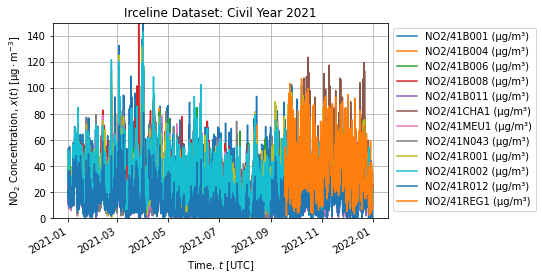

In [20]:
axe = series.loc["2021",:].plot()
axe.set_title("Irceline Dataset: Civil Year 2021")
axe.set_xlabel(r"Time, $t$ [UTC]")
axe.set_ylabel(r"$\mathrm{NO}_2$ Concentration, $x(t)$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_ylim([0, 150])
axe.grid()

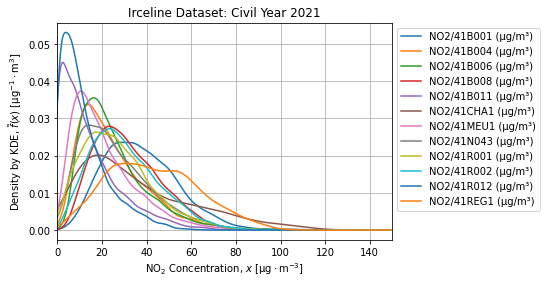

In [21]:
axe = series.loc["2021",:].plot(kind="kde")
axe.set_title("Irceline Dataset: Civil Year 2021")
axe.set_xlabel(r"$\mathrm{NO}_2$ Concentration, $x$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.set_ylabel(r"Density by KDE, $\tilde{f}(x)$ $[\mathrm{\mu g^{-1} \cdot m^{3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_xlim([0, 150])
axe.grid()

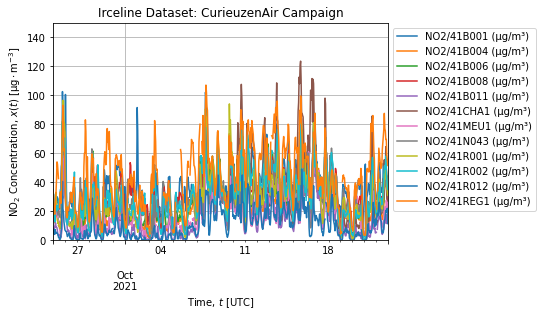

In [22]:
axe = sample.plot()
axe.set_title("Irceline Dataset: CurieuzenAir Campaign")
axe.set_xlabel(r"Time, $t$ [UTC]")
axe.set_ylabel(r"$\mathrm{NO}_2$ Concentration, $x(t)$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_ylim([0, 150])
axe.grid()

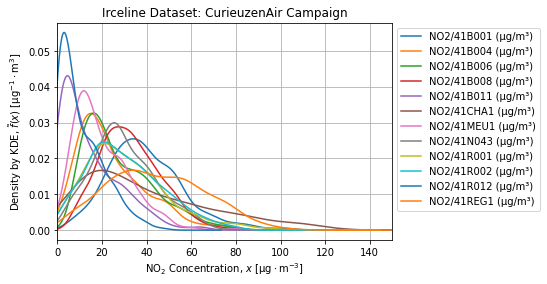

In [23]:
axe = sample.plot(kind="kde")
axe.set_title("Irceline Dataset: CurieuzenAir Campaign")
axe.set_xlabel(r"$\mathrm{NO}_2$ Concentration, $x$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.set_ylabel(r"Density by KDE, $\tilde{f}(x)$ $[\mathrm{\mu g^{-1} \cdot m^{3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_xlim([0, 150])
axe.grid()

In [24]:
period = (t1 - t0)/pd.Timedelta("1h")

In [25]:
reference = sample.agg(["count", "mean", "median",  "std"])
reference

,NO2/41B001 (µg/m³),NO2/41B004 (µg/m³),NO2/41B006 (µg/m³),NO2/41B008 (µg/m³),NO2/41B011 (µg/m³),NO2/41CHA1 (µg/m³),NO2/41MEU1 (µg/m³),NO2/41N043 (µg/m³),NO2/41R001 (µg/m³),NO2/41R002 (µg/m³),NO2/41R012 (µg/m³),NO2/41REG1 (µg/m³)
count,660.000000,659.000000,640.000000,640.000000,663.000000,307.000000,618.000000,660.000000,585.000000,660.000000,664.000000,637.000000
mean,39.332576,24.286798,27.606250,32.574219,14.442685,39.006515,19.979773,29.790909,30.551282,30.315909,10.728916,44.274725
median,37.500000,20.500000,23.000000,31.250000,10.500000,32.500000,17.000000,27.500000,27.500000,28.000000,7.500000,42.500000
std,16.689808,15.499720,15.363655,13.474936,13.198738,28.073869,12.585783,14.322995,18.088820,16.648531,9.862264,21.380994


In [26]:
reference.loc["expected",:] = period
reference.loc["performance",:] = reference.loc["count",:]/period

In [27]:
reference

,NO2/41B001 (µg/m³),NO2/41B004 (µg/m³),NO2/41B006 (µg/m³),NO2/41B008 (µg/m³),NO2/41B011 (µg/m³),NO2/41CHA1 (µg/m³),NO2/41MEU1 (µg/m³),NO2/41N043 (µg/m³),NO2/41R001 (µg/m³),NO2/41R002 (µg/m³),NO2/41R012 (µg/m³),NO2/41REG1 (µg/m³)
count,660.000000,659.000000,640.000000,640.000000,663.000000,307.000000,618.000000,660.000000,585.000000,660.000000,664.000000,637.000000
mean,39.332576,24.286798,27.606250,32.574219,14.442685,39.006515,19.979773,29.790909,30.551282,30.315909,10.728916,44.274725
median,37.500000,20.500000,23.000000,31.250000,10.500000,32.500000,17.000000,27.500000,27.500000,28.000000,7.500000,42.500000
std,16.689808,15.499720,15.363655,13.474936,13.198738,28.073869,12.585783,14.322995,18.088820,16.648531,9.862264,21.380994
expected,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
performance,0.982143,0.980655,0.952381,0.952381,0.986607,0.456845,0.919643,0.982143,0.870536,0.982143,0.988095,0.947917


In [28]:
gmeta = gmeta.merge(reference.T.reset_index().rename(columns={"index": "seriekey"}))
gmeta.to_pickle("datasets/sites.pickle")

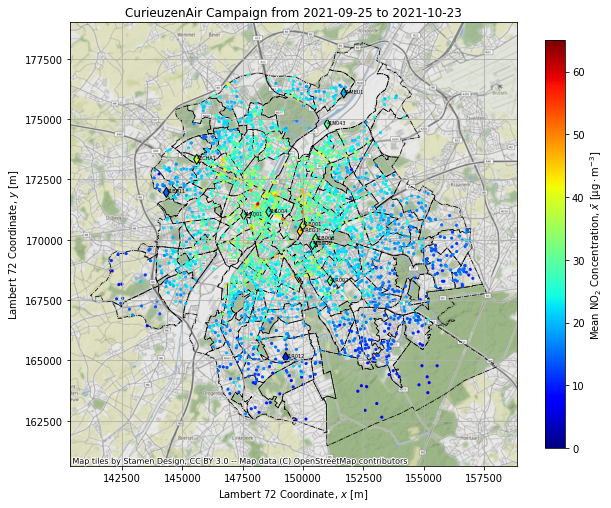

In [44]:
fig, axe = plt.subplots(figsize=(10,10))
neighboors.plot(aspect=1, linestyle="-.", color="none", edgecolor="black", linewidth=0.75, ax=axe)
cmap = axe.scatter(gdf.x, gdf.y, s=np.sqrt(20), c=gdf.no2, alpha=1.0, vmin=0., vmax=65., cmap="jet")
#gmeta.plot(marker='d', color="black", ax=axe)
axe.scatter(gmeta.geometry.x, gmeta.geometry.y, marker="d", edgecolor="black", s=50, c=gmeta["mean"], alpha=1.0, vmin=0., vmax=65., cmap="jet")
for row in gmeta.to_dict(orient="records"):
    axe.annotate(row["sitekey"], xy=(row["geometry"].x, row["geometry"].y), fontsize=5)
cb = fig.colorbar(cmap, shrink=0.75)
cb.set_label(r"Mean $\mathrm{NO}_2$ Concentration, $\bar{x}$ $[\mathrm{\mu g \cdot m^{-3}}]$")
cx.add_basemap(axe, crs=31370)
axe.set_title("CurieuzenAir Campaign from {:%Y-%m-%d} to {:%Y-%m-%d}".format(t0, t1))
axe.set_xlabel("Lambert 72 Coordinate, $x$ [m]")
axe.set_ylabel("Lambert 72 Coordinate, $y$ [m]")
axe.grid()
fig.savefig("figures/points.png", dpi=150)

In [32]:
cross = gpd.sjoin(gdf, neighboors)
cross.sample(5)

,type,cnId,muni,zip,lng,lat,green,housing,traffic,road,...,floor,type,coordinates,geometry,coords,x,y,index_right,neighboorid,neighboorname
1964,Feature,138026,1030,1030,4.373968,50.872834,green-none,housing-closed,traffic-none,road-one-way,...,1,Point,"[4.37396826, 50.87283414]",POINT (150367.112 173606.769),POINT (4.37397 50.87283),150367.111540,173606.769326,83,83,Colignon
270,Feature,131837,1180,1180,4.354209,50.799133,green-big,housing-free,traffic-none,road-two-way,...,1,Point,"[4.354209331, 50.79913347]",POINT (148974.816 165408.350),POINT (4.35421 50.79913),148974.816453,165408.350257,25,25,Observatoire
1704,Feature,136877,1210,1210,4.381944,50.851164,green-none,housing-closed,traffic-frequent,road-one-way,...,1,Point,"[4.381944363, 50.85116355]",POINT (150928.974 171196.181),POINT (4.38194 50.85116),150928.973628,171196.181291,110,110,Saint-Josse Centre
1761,Feature,136937,1000,1000,4.345285,50.851200,green-big,housing-half-open,traffic-none,road-one-way,...,1,Point,"[4.34528515, 50.8512005]",POINT (148347.464 171200.446),POINT (4.34529 50.85120),148347.464426,171200.446293,35,35,Dansaert
1148,Feature,144314,1000,1120,4.381033,50.892295,green-small,housing-closed,traffic-none,road-two-way,...,0,Point,"[4.381032854, 50.89229543]",POINT (150863.987 175771.743),POINT (4.38103 50.89230),150863.986691,175771.742851,56,56,Heembeek


In [33]:
cross.shape

(2483, 22)

In [34]:
gdf.shape

(2484, 19)

In [35]:
grouped = cross.groupby(["neighboorid", "neighboorname"])["no2"].agg(["count", "mean", "median", "std"]).reset_index()

In [42]:
neighboors = neighboors.merge(grouped, how="left")
neighboors["count"] = neighboors["count"].fillna(0)
neighboors.to_pickle("datasets/neighboors.pickle")

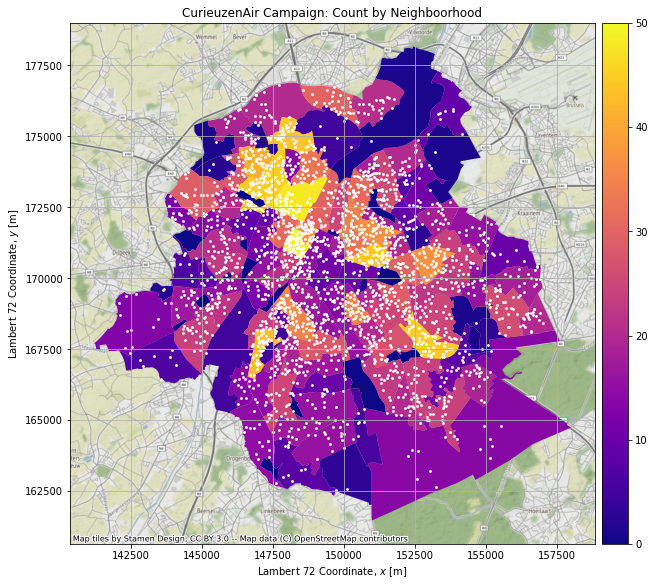

In [59]:
fig, axe = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(axe)
caxe = divider.append_axes("right", size="5%", pad=0.1)
neighboors.plot(column="count", cmap="plasma", vmin=0., vmax=50., legend=True, ax=axe, cax=caxe)
axe.scatter(gdf.x, gdf.y, s=np.sqrt(10), color="white")
cx.add_basemap(axe, crs=31370)
axe.set_title("CurieuzenAir Campaign: Count by Neighboorhood")
axe.set_xlabel("Lambert 72 Coordinate, $x$ [m]")
axe.set_ylabel("Lambert 72 Coordinate, $y$ [m]")
axe.grid()
fig.savefig("figures/counts.png", dpi=150)

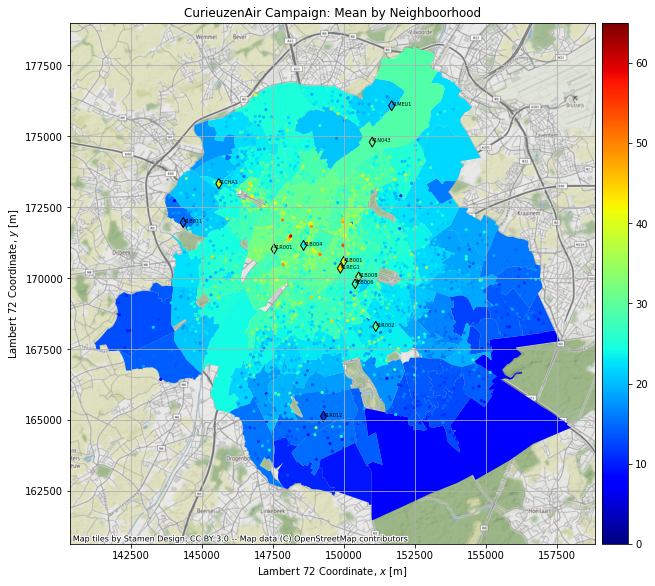

In [71]:
fig, axe = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(axe)
caxe = divider.append_axes("right", size="5%", pad=0.1)
neighboors.plot(column="mean", cmap="jet", vmin=0., vmax=65., legend=True, ax=axe, cax=caxe)
cmap = axe.scatter(gdf.x, gdf.y, s=np.sqrt(20), c=gdf.no2, alpha=1.0, vmin=0., vmax=65., cmap="jet")
axe.scatter(gmeta.geometry.x, gmeta.geometry.y, marker="d", edgecolor="black", s=50, c=gmeta["mean"], alpha=1.0, vmin=0., vmax=65., cmap="jet")
for row in gmeta.to_dict(orient="records"):
    axe.annotate(row["sitekey"], xy=(row["geometry"].x, row["geometry"].y), fontsize=5)
cx.add_basemap(axe, crs=31370)
caxe.set_label(r"Mean $\mathrm{NO}_2$ Concentration, $\bar{x}$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.set_title("CurieuzenAir Campaign: Mean by Neighboorhood")
axe.set_xlabel("Lambert 72 Coordinate, $x$ [m]")
axe.set_ylabel("Lambert 72 Coordinate, $y$ [m]")
axe.grid()
fig.savefig("figures/mean.png", dpi=150)

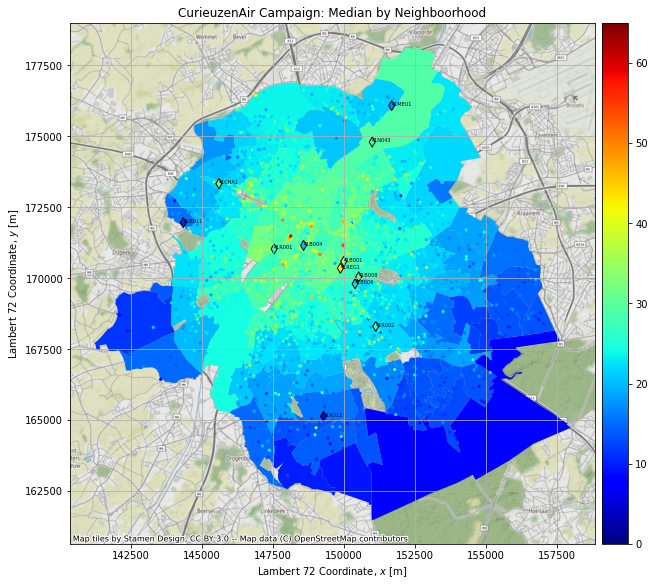

In [70]:
fig, axe = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(axe)
caxe = divider.append_axes("right", size="5%", pad=0.1)
neighboors.plot(column="median", cmap="jet", vmin=0., vmax=65., legend=True, ax=axe, cax=caxe)
cmap = axe.scatter(gdf.x, gdf.y, s=np.sqrt(20), c=gdf.no2, alpha=1.0, vmin=0., vmax=65., cmap="jet")
axe.scatter(gmeta.geometry.x, gmeta.geometry.y, marker="d", edgecolor="black", s=50, c=gmeta["median"], alpha=1.0, vmin=0., vmax=65., cmap="jet")
for row in gmeta.to_dict(orient="records"):
    axe.annotate(row["sitekey"], xy=(row["geometry"].x, row["geometry"].y), fontsize=5)
cx.add_basemap(axe, crs=31370)
caxe.set_label(r"Median $\mathrm{NO}_2$ Concentration, $\bar{x}$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.set_title("CurieuzenAir Campaign: Median by Neighboorhood")
axe.set_xlabel("Lambert 72 Coordinate, $x$ [m]")
axe.set_ylabel("Lambert 72 Coordinate, $y$ [m]")
axe.grid()
fig.savefig("figures/median.png", dpi=150)